In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib import font_manager,rc  #한글 폰트 입력을 위한 라이브러리

#폰트 경로 가져오기
font_path = 'C:\\Windows\\Fonts\\SGL.ttf' #삼성고딕체
 
# 폰트 이름 얻어오기
font_name = font_manager.FontProperties(fname=font_path).get_name()
 
#폰트 설정하기
mpl.rc('font',family=font_name)

In [2]:
workdir = "C:/Users/smcljy/data/20211115_Factsheet/data"
file_path = '{}/NUM_DATA.dta'.format(workdir)

data = pd.read_stata(file_path)

# data = pd.merge(data1,data2, on=['ID','ORDR_YMD'], how="left")

# 조건별 그룹 설정

### 정상, 기타 결과 그룹 분리

In [3]:
GRP = 'DYSLIPID'

In [4]:
data.loc[(data['BL3113'] >= 240) | (data['BL314201'] >= 160 ) | (data['BL3141'] >= 200 ) | (data['BL3142'] < 40 ) | (data['TRT_MED_HYPERLIPIDEMIA'] == '1'), GRP] = '이상지질혈증'
# data.loc[(data['BL3164'] >= 6.5) | (data['TRT_MED_DIABETES'] == '1'), GRP] = '당뇨'
data['DYSLIPID'].fillna('정상',inplace=True)

In [5]:
data.loc[data['GEND_CD'] == 'M', 'GENDER'] = '남'
data.loc[data['GEND_CD'] == 'F', 'GENDER'] = '여'

In [6]:
data.loc[ data['AGE'] < 30                      ,'AGEGRP'] = '0~29세'
data.loc[(data['AGE'] > 29) & (data['AGE'] < 40),'AGEGRP'] = '30~39세'
data.loc[(data['AGE'] > 39) & (data['AGE'] < 50),'AGEGRP'] = '40~49세'
data.loc[(data['AGE'] > 49) & (data['AGE'] < 60),'AGEGRP'] = '50~59세'
data.loc[(data['AGE'] > 59) & (data['AGE'] < 70),'AGEGRP'] = '60~69세'
data.loc[ data['AGE'] > 69                      ,'AGEGRP'] = '70세 이상'
# data.head(100)

### 특정 그룹 별도 저장 - 이상지질혈증(Dyslipidemia)은 control군 배제

In [7]:
dysl_ctrl = data.drop(data.loc[data[GRP]!='이상지질혈증'].index)
dysl_ctrl.loc[(dysl_ctrl['TRT_MED_HYPERLIPIDEMIA'] == '1'), '{}_CTRL_YN'.format(GRP)] = '치료군'
dysl_ctrl['{}_CTRL_YN'.format(GRP)].fillna('비치료군',inplace=True)
# dysl_ctrl

In [8]:
data_m = data.drop(data.loc[data['GEND_CD']=='F'].index)
data_f = data.drop(data.loc[data['GEND_CD']=='M'].index)

In [9]:
data_ctrl_m = dysl_ctrl.drop(dysl_ctrl.loc[dysl_ctrl['GEND_CD']=='F'].index)
data_ctrl_f = dysl_ctrl.drop(dysl_ctrl.loc[dysl_ctrl['GEND_CD']=='M'].index)

## pivot table create

In [10]:
dysl_cnt_m = data_m.pivot_table(
                             index=[GRP,'GENDER']
                            ,columns=['AGEGRP']
    ,values=['ID']
    ,aggfunc='count'
    ,margins=True
    ,fill_value=0
                            )

# dysl_cnt_m
# dysl_per_m = round(dysl_cnt_m.div(dysl_cnt_m.iloc[-1,-1], axis=0).astype(float)*100,1) # total value
# each column total value percentile
dysl_per_m = round(dysl_cnt_m.div(dysl_cnt_m.iloc[-1], axis=1).astype(float)*100,1)

# dysl_per_m

dysl_agegrp_m = pd.DataFrame()

for i in range(len(dysl_cnt_m.columns)):
    if i == 0:
        dysl_agegrp_m = pd.concat(
                                [
                                 dysl_cnt_m.iloc[:,i]
                                ,dysl_per_m.iloc[:,i]
                                ]
                            ,axis=1
        )
    else:
        dysl_agegrp_m = pd.concat(
                                [
                                 dysl_agegrp_m
                                ,dysl_cnt_m.iloc[:,i]
                                ,dysl_per_m.iloc[:,i]
                                ]
                            ,axis=1
        )
        
# dysl_agegrp_m

In [11]:
dysl_cnt_f = data_f.pivot_table(
                             index=[GRP,'GENDER']
                            ,columns=['AGEGRP']
    ,values=['ID']
    ,aggfunc='count'
    ,margins=True
    ,fill_value=0
                            )

# dysl_cnt_f
# dysl_per_f = round(dysl_cnt_f.div(dysl_cnt_f.iloc[-1,-1], axis=0).astype(float)*100,1) # total value
# each column total value percentile
dysl_per_f = round(dysl_cnt_f.div(dysl_cnt_f.iloc[-1], axis=1).astype(float)*100,1)

# dysl_per_f

dysl_agegrp_f = pd.DataFrame()

for i in range(len(dysl_cnt_f.columns)):
    if i == 0:
        dysl_agegrp_f = pd.concat(
                                [
                                 dysl_cnt_f.iloc[:,i]
                                ,dysl_per_f.iloc[:,i]
                                ]
                            ,axis=1
        )
    else:
        dysl_agegrp_f = pd.concat(
                                [
                                 dysl_agegrp_f
                                ,dysl_cnt_f.iloc[:,i]
                                ,dysl_per_f.iloc[:,i]
                                ]
                            ,axis=1
        )
        
# dysl_agegrp_f

In [12]:
dysl_agegrp = pd.concat([dysl_agegrp_m.iloc[:-1,:], dysl_agegrp_f.iloc[:-1,:]],axis=0)
# dysl_agegrp = pd.concat([dysl_agegrp_m, dysl_agegrp_f],axis=0)
dysl_agegrp_label = []

for i in range(len(dysl_agegrp.columns)):
    dysl_agegrp_label.append(dysl_agegrp.columns[i][1])
    
dysl_agegrp.columns = dysl_agegrp_label
# dysl_agegrp.set_index(dysl_agegrp.index.names,inplace=True)
dysl_agegrp = dysl_agegrp.sort_index()

labels = []
for i in range(len(dysl_per_m.columns)-1):
    labels.append(dysl_per_m.columns[i][1])
    
# dysl_agegrp

In [13]:
dysl_cnt_t = data.pivot_table(
                             index=[GRP]#,'GENDER']
                            ,columns=['AGEGRP']
    ,values=['ID']
    ,aggfunc='count'
    ,margins=True
    ,fill_value=0
                            )

# total value percentile
dysl_per_t = round(dysl_cnt_t.div(dysl_cnt_t.iloc[-1,-1], axis=0).astype(float)*100,1)

dysl_per_t

dysl_agegrp_t = pd.DataFrame()

for i in range(len(dysl_cnt_t.columns)):
    if i == 0:
        dysl_agegrp_t = pd.concat(
                                [
                                 dysl_cnt_t.iloc[:,i]
                                ,dysl_per_t.iloc[:,i]
                                ]
                            ,axis=1
        )
    else:
        dysl_agegrp_t = pd.concat(
                                [
                                 dysl_agegrp_t
                                ,dysl_cnt_t.iloc[:,i]
                                ,dysl_per_t.iloc[:,i]
                                ]
                            ,axis=1
        )

# dysl_agegrp_t

In [14]:
dysl_cnt_subt = data.pivot_table(
                             index=[GRP]#,'GENDER']
                            ,columns=['AGEGRP']
    ,values=['ID']
    ,aggfunc='count'
    ,margins=True
    ,fill_value=0
                            )

# total value percentile
# dysl_per_t = round(dysl_cnt_t.div(dysl_cnt_t.iloc[-1,-1], axis=0).astype(float)*100,1)
# 211123 기준 변경
dysl_per_subt = round(dysl_cnt_subt.div(dysl_cnt_subt.iloc[-1], axis=1).astype(float)*100,1)

dysl_per_subt

dysl_agegrp_subt = pd.DataFrame()

for i in range(len(dysl_cnt_subt.columns)):
    if i == 0:
        dysl_agegrp_subt = pd.concat(
                                [
                                 dysl_cnt_subt.iloc[:,i]
                                ,dysl_per_subt.iloc[:,i]
                                ]
                            ,axis=1
        )
    else:
        dysl_agegrp_subt = pd.concat(
                                [
                                 dysl_agegrp_subt
                                ,dysl_cnt_subt.iloc[:,i]
                                ,dysl_per_subt.iloc[:,i]
                                ]
                            ,axis=1
        )

# dysl_agegrp_subt

### cure group data

In [15]:
dysl_ctrl_cnt_m = data_ctrl_m.pivot_table(
                             index=['{}_CTRL_YN'.format(GRP),'GENDER']
                            ,columns=['AGEGRP']
    ,values=['ID']
    ,aggfunc='count'
    ,margins=True
    ,fill_value=0
                            )

# dysl_ctrl_cnt_m
# dysl_per_m = round(dysl_cnt_m.div(dysl_cnt_m.iloc[-1,-1], axis=0).astype(float)*100,1) # total value
# each column total value percentile
dysl_ctrl_per_m = round(dysl_ctrl_cnt_m.div(dysl_ctrl_cnt_m.iloc[-1], axis=1).astype(float)*100,1)

# dysl_ctrl_per_m

dysl_ctrl_agegrp_m = pd.DataFrame()

for i in range(len(dysl_ctrl_cnt_m.columns)):
    if i == 0:
        dysl_ctrl_agegrp_m = pd.concat(
                                [
                                 dysl_ctrl_cnt_m.iloc[:,i]
                                ,dysl_ctrl_per_m.iloc[:,i]
                                ]
                            ,axis=1
        )
    else:
        dysl_ctrl_agegrp_m = pd.concat(
                                [
                                 dysl_ctrl_agegrp_m
                                ,dysl_ctrl_cnt_m.iloc[:,i]
                                ,dysl_ctrl_per_m.iloc[:,i]
                                ]
                            ,axis=1
        )
        
# dysl_ctrl_agegrp_m

In [16]:
dysl_ctrl_cnt_f = data_ctrl_f.pivot_table(
                             index=['{}_CTRL_YN'.format(GRP),'GENDER']
                            ,columns=['AGEGRP']
    ,values=['ID']
    ,aggfunc='count'
    ,margins=True
    ,fill_value=0
                            )

# dysl_ctrl_cnt_m
# dysl_per_m = round(dysl_cnt_m.div(dysl_cnt_m.iloc[-1,-1], axis=0).astype(float)*100,1) # total value
# each column total value percentile
dysl_ctrl_per_f = round(dysl_ctrl_cnt_f.div(dysl_ctrl_cnt_f.iloc[-1], axis=1).astype(float)*100,1)

# dysl_ctrl_per_m

dysl_ctrl_agegrp_f = pd.DataFrame()

for i in range(len(dysl_ctrl_cnt_f.columns)):
    if i == 0:
        dysl_ctrl_agegrp_f = pd.concat(
                                [
                                 dysl_ctrl_cnt_f.iloc[:,i]
                                ,dysl_ctrl_per_f.iloc[:,i]
                                ]
                            ,axis=1
        )
    else:
        dysl_ctrl_agegrp_f = pd.concat(
                                [
                                 dysl_ctrl_agegrp_f
                                ,dysl_ctrl_cnt_f.iloc[:,i]
                                ,dysl_ctrl_per_f.iloc[:,i]
                                ]
                            ,axis=1
        )
        
# dysl_ctrl_agegrp_f

In [17]:
dysl_ctrl_agegrp = pd.concat([dysl_ctrl_agegrp_m.iloc[:-1,:], dysl_ctrl_agegrp_f.iloc[:-1,:]],axis=0)
# dysl_agegrp = pd.concat([dysl_agegrp_m, dysl_agegrp_f],axis=0)
dysl_ctrl_agegrp_label = []

for i in range(len(dysl_ctrl_agegrp.columns)):
    dysl_ctrl_agegrp_label.append(dysl_ctrl_agegrp.columns[i][1])
    
dysl_ctrl_agegrp.columns = dysl_ctrl_agegrp_label
# dysl_agegrp.set_index(dysl_agegrp.index.names,inplace=True)
dysl_ctrl_agegrp = dysl_ctrl_agegrp.sort_index()

# dysl_ctrl_agegrp

In [18]:
dysl_ctrl_cnt_t = dysl_ctrl.pivot_table(
                             index=['{}_CTRL_YN'.format(GRP)]#,'GENDER']
                            ,columns=['AGEGRP']
    ,values=['ID']
    ,aggfunc='count'
    ,margins=True
    ,fill_value=0
                            )

# dysl_ctrl_cnt_t

# total value percentile
dysl_ctrl_per_t = round(dysl_ctrl_cnt_t.div(dysl_ctrl_cnt_t.iloc[-1,-1], axis=0).astype(float)*100,1)

dysl_ctrl_per_t

dysl_ctrl_agegrp_t = pd.DataFrame()

for i in range(len(dysl_ctrl_cnt_t.columns)):
    if i == 0:
        dysl_ctrl_agegrp_t = pd.concat(
                                [
                                 dysl_ctrl_cnt_t.iloc[:,i]
                                ,dysl_ctrl_per_t.iloc[:,i]
                                ]
                            ,axis=1
        )
    else:
        dysl_ctrl_agegrp_t = pd.concat(
                                [
                                 dysl_ctrl_agegrp_t
                                ,dysl_ctrl_cnt_t.iloc[:,i]
                                ,dysl_ctrl_per_t.iloc[:,i]
                                ]
                            ,axis=1
        )

# dysl_ctrl_agegrp_t

In [19]:
dysl_ctrl_cnt_subt = dysl_ctrl.pivot_table(
                             index=['{}_CTRL_YN'.format(GRP)]#,'GENDER']
                            ,columns=['AGEGRP']
    ,values=['ID']
    ,aggfunc='count'
    ,margins=True
    ,fill_value=0
                            )

# dysl_ctrl_cnt_t

# total value percentile
dysl_ctrl_per_subt = round(dysl_ctrl_cnt_subt.div(dysl_ctrl_cnt_subt.iloc[-1], axis=1).astype(float)*100,1)

dysl_ctrl_agegrp_subt = pd.DataFrame()

for i in range(len(dysl_ctrl_cnt_subt.columns)):
    if i == 0:
        dysl_ctrl_agegrp_subt = pd.concat(
                                [
                                 dysl_ctrl_cnt_subt.iloc[:,i]
                                ,dysl_ctrl_per_subt.iloc[:,i]
                                ]
                            ,axis=1
        )
    else:
        dysl_ctrl_agegrp_subt = pd.concat(
                                [
                                 dysl_ctrl_agegrp_subt
                                ,dysl_ctrl_cnt_subt.iloc[:,i]
                                ,dysl_ctrl_per_subt.iloc[:,i]
                                ]
                            ,axis=1
        )

# dysl_ctrl_agegrp_subt

# Bar chart create

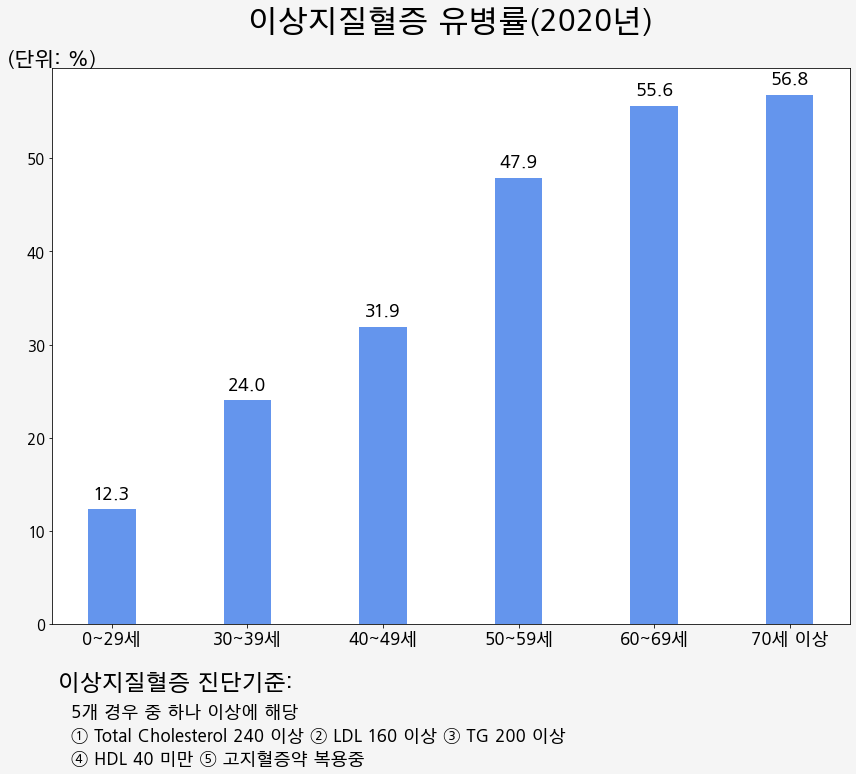

In [20]:
value01 = dysl_per_subt.iloc[0,:-1]


x = np.arange(len(labels))  # the label locations # all 값이 list에는 포함되지 않았기 때문임.
width = 0.35  # the width of the bars

# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(12, 11),linewidth=2) # 캔버스 배경 사이즈 설정

fig.set_facecolor('whitesmoke') ## 캔버스 배경색 설정
# rects1 = ax.bar(x,  value01, width, label='전체',color='cornflowerblue')
rects1 = ax.bar(x,  value01, width,color='cornflowerblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('이상지질혈증 유병률(2020년)\n',fontsize=30)
ax.set_ylabel(
                '(단위: %)' # 표시값
                 ,labelpad=-70 # 여백값 설정
                ,fontsize=20 # 글씨크기 설정
                ,rotation=0 # 회전값 조정
#                 ,ha='center' # 위치조정
                ,loc='top' # 위치조정, ha와 동시에 사용은 불가함.
            )
ax.yaxis.set_tick_params(labelsize=15) # y축 표시값 글씨크기 조정
ax.set_xticks(x)
ax.set_xticklabels(
                   labels[0:len(labels)] # all 값이 list에는 포함되지 않았기 때문임.
                  , fontsize=17
                  )

# bar위에 값 label 표시
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(height, 
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 8),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom'
                   ,fontsize=18
                   )

autolabel(rects1)

plt.text(-0.4, -7,  '이상지질혈증 진단기준:', fontsize=22)
plt.text(-0.3, -10, '5개 경우 중 하나 이상에 해당', fontsize=17)
plt.text(-0.3, -12.5, '① Total Cholesterol 240 이상 ② LDL 160 이상 ③ TG 200 이상', fontsize=17)
plt.text(-0.3, -15, '④ HDL 40 미만 ⑤ 고지혈증약 복용중', fontsize=17)

fig.tight_layout()

plt.savefig("{}/02_03이상지질혈증_01유병률.png".format(workdir[:-5])
            ,edgecolor='black', dpi=144) #72의 배수

# plt.show()

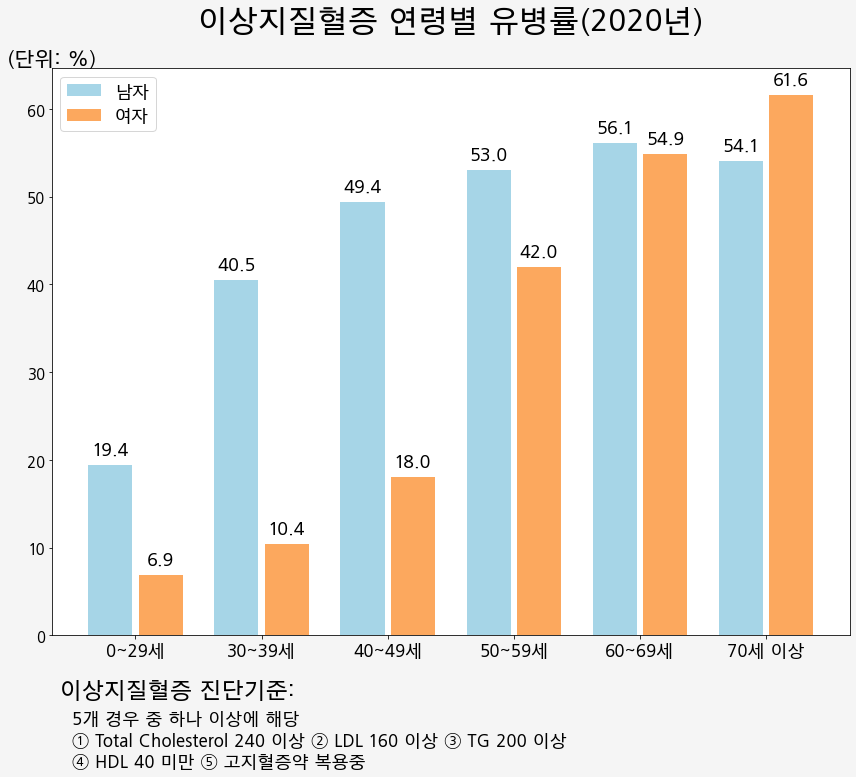

In [21]:
value01 = dysl_per_m.iloc[0,:-1]
value02 = dysl_per_f.iloc[0,:-1]

x = np.arange(len(labels))  # the label locations # all 값이 list에는 포함되지 않았기 때문임.
width = 0.35  # the width of the bars

# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(12, 11),linewidth=2) # 캔버스 배경 사이즈 설정

fig.set_facecolor('whitesmoke') ## 캔버스 배경색 설정
rects1 = ax.bar(x - 0.2, value01, width, label='남자',color=plt.get_cmap('RdYlBu')(np.linspace(0.15, 0.85,np.array(dysl_per_m.iloc[0,:-1]).shape[0]))[4])
rects2 = ax.bar(x + 0.2, value02, width, label='여자',color=plt.get_cmap('RdYlBu')(np.linspace(0.15, 0.85,np.array(dysl_per_m.iloc[0,:-1]).shape[0]))[1])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('이상지질혈증 연령별 유병률(2020년)\n',fontsize=30)
ax.set_ylabel(
                '(단위: %)' # 표시값
                 ,labelpad=-70 # 여백값 설정
                ,fontsize=20 # 글씨크기 설정
                ,rotation=0 # 회전값 조정
#                 ,ha='center' # 위치조정
                ,loc='top' # 위치조정, ha와 동시에 사용은 불가함.
            )
ax.yaxis.set_tick_params(labelsize=15) # y축 표시값 글씨크기 조정
ax.set_xticks(x)
ax.set_xticklabels(
                   labels[0:len(labels)] # all 값이 list에는 포함되지 않았기 때문임.
                  , fontsize=17
                  )

ax.legend(fontsize=17)
# ax.legend(bbox_to_anchor=(0.5,-0.18), title='LEGEND01', title_fontsize = 17 ,ncol=6  ,loc='lower center' ,fontsize=15)

# bar위에 값 label 표시
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(height, 
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 8),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom'
                   ,fontsize=18
                   )

autolabel(rects1)
autolabel(rects2)

plt.text(-0.6, -7,  '이상지질혈증 진단기준:', fontsize=22)
plt.text(-0.5, -10, '5개 경우 중 하나 이상에 해당', fontsize=17)
plt.text(-0.5, -12.5, '① Total Cholesterol 240 이상 ② LDL 160 이상 ③ TG 200 이상', fontsize=17)
plt.text(-0.5, -15, '④ HDL 40 미만 ⑤ 고지혈증약 복용중', fontsize=17)

fig.tight_layout()

plt.savefig("{}/02_03이상지질혈증_02연령별유병률.png".format(workdir[:-5])
            ,edgecolor='black', dpi=144) #72의 배수
plt.show()

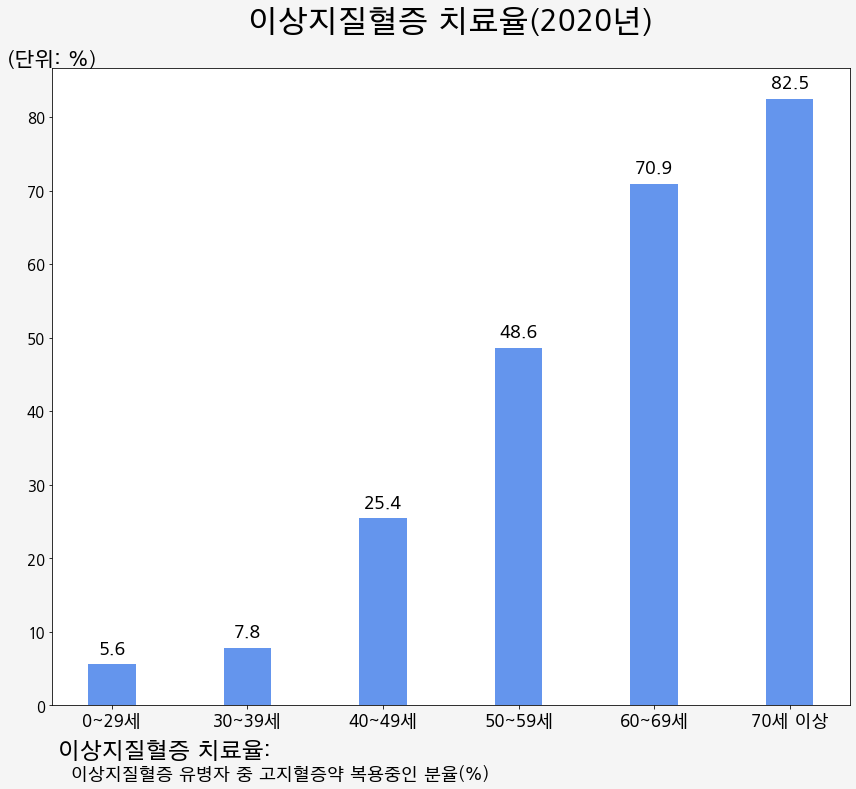

In [22]:
value01 = dysl_ctrl_per_subt.iloc[1,:-1]


x = np.arange(len(labels))  # the label locations # all 값이 list에는 포함되지 않았기 때문임.
width = 0.35  # the width of the bars

# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(12, 11),linewidth=2) # 캔버스 배경 사이즈 설정

fig.set_facecolor('whitesmoke') ## 캔버스 배경색 설정
rects1 = ax.bar(x,  value01, width,color='cornflowerblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('이상지질혈증 치료율(2020년)\n',fontsize=30)
ax.set_ylabel(
                '(단위: %)' # 표시값
                 ,labelpad=-70 # 여백값 설정
                ,fontsize=20 # 글씨크기 설정
                ,rotation=0 # 회전값 조정
#                 ,ha='center' # 위치조정
                ,loc='top' # 위치조정, ha와 동시에 사용은 불가함.
            )
ax.yaxis.set_tick_params(labelsize=15) # y축 표시값 글씨크기 조정
ax.set_xticks(x)
ax.set_xticklabels(
                   labels[0:len(labels)] # all 값이 list에는 포함되지 않았기 때문임.
                  , fontsize=17
                  )

# bar위에 값 label 표시
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(height, 
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 8),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom'
                   ,fontsize=18
                   )

autolabel(rects1)

plt.text(-0.4, -7,  '이상지질혈증 치료율:', fontsize=22)
plt.text(-0.3, -10, '이상지질혈증 유병자 중 고지혈증약 복용중인 분율(%)', fontsize=17)

fig.tight_layout()

plt.savefig("{}/02_03이상지질혈증_03치료율.png".format(workdir[:-5])
            ,edgecolor='black', dpi=144) #72의 배수

# plt.savefig("{}/dysl_ctrl_t.png".format(workdir),edgecolor="black")

# plt.show()

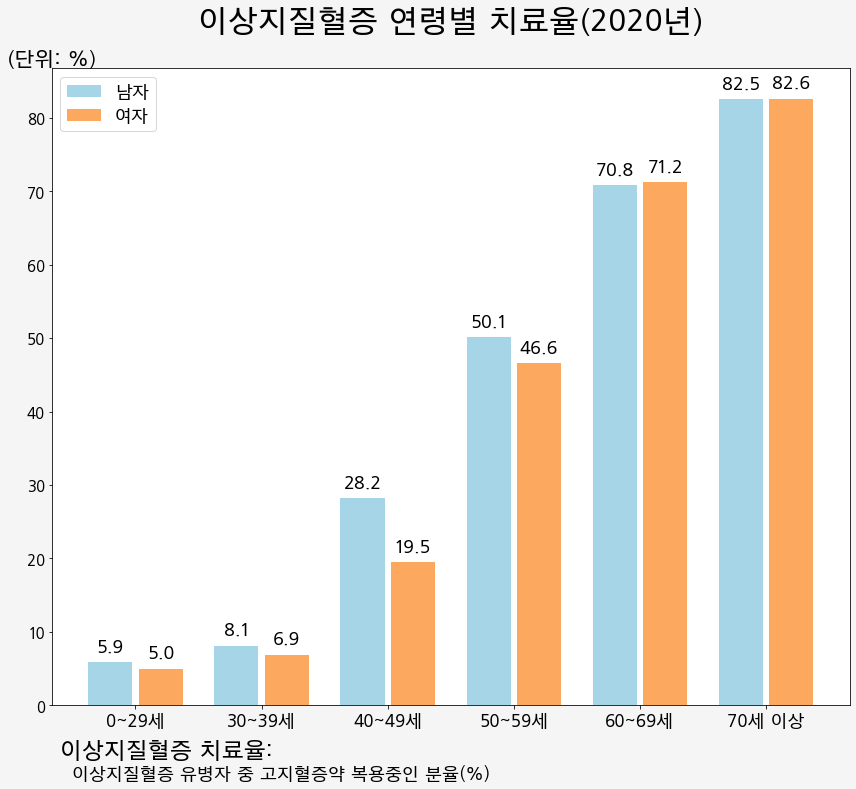

In [23]:
value01 = dysl_ctrl_per_m.iloc[1,:-1]
value02 = dysl_ctrl_per_f.iloc[1,:-1]

x = np.arange(len(labels))  # the label locations # all 값이 list에는 포함되지 않았기 때문임.
width = 0.35  # the width of the bars

# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(12, 11),linewidth=2) # 캔버스 배경 사이즈 설정

fig.set_facecolor('whitesmoke') ## 캔버스 배경색 설정
rects1 = ax.bar(x - 0.2, value01, width, label='남자',color=plt.get_cmap('RdYlBu')(np.linspace(0.15, 0.85,np.array(dysl_ctrl_per_m.iloc[0,:-1]).shape[0]))[4])
rects2 = ax.bar(x + 0.2, value02, width, label='여자',color=plt.get_cmap('RdYlBu')(np.linspace(0.15, 0.85,np.array(dysl_ctrl_per_m.iloc[0,:-1]).shape[0]))[1])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('이상지질혈증 연령별 치료율(2020년)\n',fontsize=30)
ax.set_ylabel(
                '(단위: %)' # 표시값
                 ,labelpad=-70 # 여백값 설정
                ,fontsize=20 # 글씨크기 설정
                ,rotation=0 # 회전값 조정
#                 ,ha='center' # 위치조정
                ,loc='top' # 위치조정, ha와 동시에 사용은 불가함.
            )
ax.yaxis.set_tick_params(labelsize=15) # y축 표시값 글씨크기 조정
ax.set_xticks(x)
ax.set_xticklabels(
                   labels[0:len(labels)] # all 값이 list에는 포함되지 않았기 때문임.
                  , fontsize=17
                  )
ax.legend(fontsize=17)

# bar위에 값 label 표시
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(height, 
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 8),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom'
                   ,fontsize=18
                   )

autolabel(rects1)
autolabel(rects2)

plt.text(-0.6, -7,  '이상지질혈증 치료율:', fontsize=22)
plt.text(-0.5, -10, '이상지질혈증 유병자 중 고지혈증약 복용중인 분율(%)', fontsize=17)

fig.tight_layout()

plt.savefig("{}/02_03이상지질혈증_04연령별치료율.png".format(workdir[:-5])
            ,edgecolor='black', dpi=144) #72의 배수
# plt.savefig("{}/dysl_ctrl_mf.png".format(workdir),edgecolor="black")

# plt.show()

# data merge, export

In [ ]:
dysl_agegrp_t.to_excel('{}/02_03이상지질혈증.xlsx'.format(workdir[:-5]),sheet_name="유병률")
with pd.ExcelWriter('{}/02_03이상지질혈증.xlsx'.format(workdir[:-5]), mode='a',engine='openpyxl') as writer:
    dysl_agegrp.to_excel(writer,sheet_name="연령별유병률")
    dysl_ctrl_agegrp_t.to_excel(writer,sheet_name="치료율")
    dysl_ctrl_agegrp.to_excel(writer,sheet_name="연령별치료율")